In [2]:
using Revise
using Pkg; Pkg.activate(".")
using HypergraphModularity
using StatsBase
using DataFrames
using RCall
using SparseArrays
using Clustering
using CSV

 Activating environment at `~/hypergraph_modularities_code/Project.toml`


In [5]:
function recoveryExperiment(; data, n_rounds = 2, core = 0, Γ₀ = 100.0, γ₀ = 1.0, kmax = 20, save_as = "recovery_throughput/experiment.csv")
    
    # collector
    DF = DataFrame()

    H, Z = read_hypergraph_data(data, kmax)
    
    H, Z = kcore(H, Z, core)
    n = length(H.D)
    
    kmin = minimum([k for k in keys(H.E) if length(H.E[k]) > 0])
    
    println("$(core)-core of $(data) has $n nodes")
    
    for k ∈ reverse(kmin:kmax)
        # remove edges of size larger than k
        removeEdges!(H; remove = collect((k+1):(kmax+1)))
        
        m = sum(length(H.E[k]) for k in keys(H.E))
        
        # polyadic warmstart
        D = big(sum(H.D))

        ωᵢ = 2.0
        ωₒ = 0.6
        function ω(p, α)
            num = p[1] == 1 ? ωᵢ : ωₒ
            denom = D^sum(p[2])
            return Γ₀*num / denom
        end
        
        Ω̂ = allOrNothingIntensityFunction(ω, maximum(keys(H.E)))
        Ẑ_w = SuperNode_PPLouvain(H, Ω̂; α = 0, verbose = false, Z0 = collect(1:n));
        
        # polyadic experiments
        for i ∈ 1:n_rounds 
            Ẑ, t = @timed SuperNode_PPLouvain(H, Ω̂; α = 0, verbose = false, scan_order = "random")
            Ω̄ = estimateΩEmpirically(H, Ẑ; aggregator = p -> [length(p) == 1, sum(p)])

            Q = modularity(H, Ẑ, Ω̂; α = 0)
            ℓ = length(unique(Ẑ))    
            ARI = randindex(Z, Ẑ)[1]
            df = DataFrame(data = data, kmax = k, ℓ = ℓ, Q = Q, t = t, ARI = ARI, method = "Polyadic", n = n, core = core, round = i, thread = Threads.threadid(), m = m)
            DF = vcat(DF, df)
        end
        
        
        # construct dyadic graph
        H̄ = projectedGraph(H)  
        
        # dyadic warmstart
        D̄ = big(sum(H̄.D))
        
#         function ω_d(p, α)
#             num = p[1] == 1 ? ωᵢ : ωₒ
#             denom = D̄^sum(p[2])
#             return γ₀*num / denom
#         end
        
#         Ω̄ = allOrNothingIntensityFunction(ω_d, 2)
#         Z̄_w = SuperNode_PPLouvain(H, Ω̄; α = 0, verbose = false, Z0 = collect(1:n));
              
        best_Z̄ = zero(Z)
        best_Q = -Inf
        
        Ω̄ = estimateΩEmpirically(H̄, Ẑ_w; aggregator = p -> [length(p) == 1, sum(p)])
        for i ∈ 1:n_rounds
            Z̄, t = @timed SuperNode_PPLouvain(H̄, Ω̄; α = 0, verbose = false)
            Ω̄ = estimateΩEmpirically(H̄, Z̄; aggregator = p -> [length(p) == 1, sum(p)])
            Q = modularity(H̄, Z̄, Ω̄; α = 0)
            ℓ = length(unique(Z̄))
            ARI = randindex(Z, Z̄)[1]
            df = DataFrame(data = data, kmax = k, ℓ = ℓ, Q = Q, method = "Dyadic", t = t, ARI = ARI, n = n, core = core, round = i, thread = Threads.threadid(), m = m)
            DF = vcat(DF, df)
            
                        
            if Q > best_Q
                best_Q = Q
                best_Z̄ = Z̄
            end   
        end
        
        # dyadic with weighted projection

        γ = computeDyadicResolutionParameter(H, Ẑ_w; mode = "γ", weighted = true)
        
        for i ∈ 1:n_rounds
            Z̄, t = @timed CliqueExpansionModularity(H, γ; weighted = true)
            γ = computeDyadicResolutionParameter(H, Z̄; mode = "γ", weighted = true)
            Ω̄ = estimateΩEmpirically(H̄, Z̄; aggregator = p -> [length(p) == 1, sum(p)])
            Q = modularity(H̄, Z̄, Ω̄; α = 0)
            ℓ = length(unique(Z̄))
            ARI = randindex(Z, Z̄)[1]
            df = DataFrame(data = data, kmax = k, ℓ = ℓ, Q = Q, method = "Dyadic (weighted)", t = t, ARI = ARI, n = n, core = core, round = i, thread = Threads.threadid(), m = m)
            DF = vcat(DF, df)           
        end
        
        # refinement
        Ẑ = best_Z̄    
        for i ∈ 1:n_rounds
            Ω̂ = estimateΩEmpirically(H, Ẑ; aggregator = p -> [length(p) == 1, sum(p)])
            Ẑ, t = @timed SuperNode_PPLouvain(H, Ω̂; Z0 = Ẑ, α = 0, scan_order = "random", verbose = false)
            Q = modularity(H, Ẑ, Ω̂; α = 0)
            ℓ = length(unique(Ẑ))    
            ARI = randindex(Z, Ẑ)[1]
            df = DataFrame(data = data, kmax = k, ℓ = ℓ, Q = Q, t = t, ARI = ARI, method = "Polyadic Refinement", n = n, core = core, round = i, thread = Threads.threadid(), m = m)
            DF = vcat(DF, df)
        end  
    end
    
    path = "fig/recovery_throughput/$(save_as).csv"
    CSV.write(path, DF)
    return DF
end

recoveryExperiment (generic function with 1 method)

# Troubleshooting

In [34]:
n_rounds = 5
kmax = 10

control = [Dict(:data => "SN-congress-bills", :core => 0,  :n_rounds => n_rounds, :Γ₀ => 10000.0, :γ₀ => 1000.0, :kmax => kmax, :save_as => "SN-congress-bills"),]

df = recoveryExperiment(;control[1]...);

0-core of SN-congress-bills has 294 nodes


In [35]:
using RCall

R"""
library(tidyverse)
""";

In [36]:
R"""
df <- tibble($df)

df %>% 
    filter(method == "Dyadic (weighted)", kmax <= 6)
"""

RObject{VecSxp}
# A tibble: 25 x 12
   data   kmax     ℓ       Q      t      ARI method     n  core round thread
   <chr> <int> <int>   <dbl>  <dbl>    <dbl> <chr>  <int> <int> <int>  <int>
 1 SN-c…     6     6 -6.74e5 0.0759  1.01e-2 Dyadi…   294     0     1      1
 2 SN-c…     6     5 -6.77e5 0.0540 -2.01e-3 Dyadi…   294     0     2      1
 3 SN-c…     6     4 -6.84e5 0.0487 -3.07e-4 Dyadi…   294     0     3      1
 4 SN-c…     6   294 -6.83e5 0.0197  0.      Dyadi…   294     0     4      1
 5 SN-c…     6     4 -6.84e5 0.0272 -3.07e-4 Dyadi…   294     0     5      1
 6 SN-c…     5     6 -4.56e5 0.0536  1.24e-2 Dyadi…   294     0     1      1
 7 SN-c…     5     5 -4.58e5 0.0873 -6.61e-5 Dyadi…   294     0     2      1
 8 SN-c…     5     4 -4.63e5 0.0538 -3.07e-4 Dyadi…   294     0     3      1
 9 SN-c…     5   294 -4.63e5 0.0156  0.      Dyadi…   294     0     4      1
10 SN-c…     5     4 -4.63e5 0.0234 -3.07e-4 Dyadi…   294     0     5      1
# … with 15 more rows, and 1 more variab

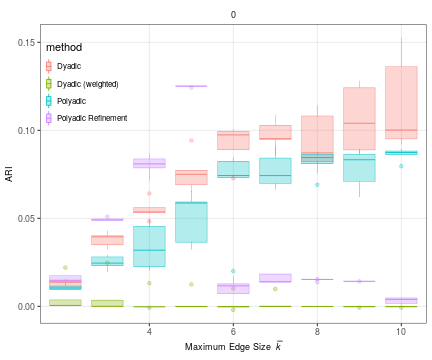

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Duplicated override.aes is ignored.
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [37]:
R"""
df <- tibble($df)

df %>% arrange(desc(round)) %>% 
    group_by(method, kmax, core) %>% 
    mutate(n_ = format(n,big.mark=",",scientific=FALSE)) %>% 
#    filter(Q == max(Q)) %>% 
    ggplot() + 
    aes(x = factor(kmax), y = ARI) + 
    geom_boxplot(aes(color = method, fill = method),  lwd = 0.2, outlier.alpha = 0.3, position = position_identity(), alpha = 0.3) + 
    facet_grid(~core) + 
    xlab(expression("Maximum Edge Size"~italic(bar(k)))) + 
    theme_bw() +
    theme(strip.background = element_blank(),
          panel.spacing = unit(3, "mm"),
          strip.text = element_text(size = 9),
#          legend.position = "bottom",
          legend.text = element_text(size = 8),
          panel.grid.minor = element_blank(),
          legend.key.width = unit(0.4,"line"),
          legend.position = c(.12, .8),
          legend.background = element_blank(), 
          legend.key = element_rect(colour = NA, fill = NA),
          axis.title = element_text(size = 9)) +
    scale_x_discrete(breaks = seq(4, 20, by = 2)) + 
    guides(fill = guide_legend(override.aes = list(size = 0.4)), 
           color = guide_legend(override.aes = list(size = 0.4)))
"""

# Main Experiment

In [38]:
n_rounds = 20
kmax = 25

control = [
    Dict(:data => "SN-congress-bills", :core => 0,  :n_rounds => n_rounds, :Γ₀ => 10000.0, :γ₀ => 1000.0, :kmax => kmax, :save_as => "SN-congress-bills"),
    Dict(:data => "HR-congress-bills", :core => 0,  :n_rounds => n_rounds, :Γ₀ => 10000.0, :γ₀ => 1000000.0, :kmax => kmax, :save_as => "HR-congress-bills"),
    Dict(:data => "TrivagoClickout",   :core => 10, :n_rounds => n_rounds, :Γ₀ => 1000.0, :γ₀ => 1000000.0, :kmax => kmax, :save_as => "TrivagoClickout-10-core"),
    Dict(:data => "TrivagoClickout",   :core => 5,  :n_rounds => n_rounds, :Γ₀ => 1000.0, :γ₀ => 100000.0, :kmax => kmax, :save_as => "TrivagoClickout-5-core"),
    Dict(:data => "TrivagoClickout",   :core => 2,  :n_rounds => n_rounds, :Γ₀ => 1000.0, :γ₀ => 100000.0, :kmax => kmax, :save_as => "TrivagoClickout-2-core"),
    Dict(:data => "walmart-trips",     :core => 4,  :n_rounds => n_rounds, :Γ₀ => 100.0, :γ₀ => 1000.0, :kmax => kmax, :save_as => "walmart-trips-4-core"),
    Dict(:data => "walmart-trips",     :core => 3,  :n_rounds => n_rounds, :Γ₀ => 100.0, :γ₀ => 1000.0, :kmax => kmax, :save_as => "walmart-trips-3-core"),
    Dict(:data => "walmart-trips",     :core => 2,  :n_rounds => n_rounds, :Γ₀ => 100.0, :γ₀ => 100.0, :kmax => kmax, :save_as => "walmart-trips-2-core"),
    Dict(:data => "contact-primary-school-classes",     :core => 0,  :n_rounds => n_rounds, :Γ₀ => 20000.0, :γ₀ => 100.0, :kmax => 6, :save_as => "contact-primary-school"),
    Dict(:data => "contact-high-school-classes",        :core => 0,  :n_rounds => n_rounds, :Γ₀ => 10000.0, :γ₀ => 100.0, :kmax => 6, :save_as => "contact-high-school"),
];

In [ ]:
Threads.@threads for d in control
    recoveryExperiment(;d...)
end

0-core of contact-high-school-classes has 327 nodes
0-core of contact-primary-school-classes has 242 nodes
0-core of SN-congress-bills has 294 nodes
4-core of walmart-trips has 535 nodes
0-core of HR-congress-bills has 1494 nodes
3-core of walmart-trips has 1155 nodes
10-core of TrivagoClickout has 1327 nodes
2-core of walmart-trips has 15105 nodes
5-core of TrivagoClickout has 13345 nodes
2-core of TrivagoClickout has 73543 nodes
